In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import wikipedia
import xml.etree.ElementTree as ET
import re
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
import xgboost as xgb
from sklearn.metrics import r2_score

%matplotlib inline

In [2]:
df = pd.read_csv('2020.1 - sysarmy - Encuesta de remuneración salarial Argentina - Argentina.csv', skiprows=9)
df = df[df['Salario mensual BRUTO (en tu moneda local)'] < 1_000_000]
df = df[df['Años en la empresa actual'] < 40]
df = df[(df['Salario mensual BRUTO (en tu moneda local)'] >= 10_000) & (df['Salario mensual BRUTO (en tu moneda local)'] <= 1_000_000)]
df.head()
df['Bases de datos']

0                                  NaN
1           MariaDB, MySQL, PostgreSQL
2                MongoDB, MySQL, Redis
3                         MSSQL, MySQL
4                      MariaDB, SQLite
                     ...              
5976                     MySQL, SQLite
5977                             MSSQL
5978             MSSQL, MongoDB, MySQL
5979                               NaN
5980    Informix, MSSQL, MySQL, Oracle
Name: Bases de datos, Length: 5766, dtype: object

In [3]:
df_databases_cols = df['Bases de datos'].fillna('').apply(lambda pls: pd.Series([v.lower().strip() for v in pls.replace('Microsoft Azure (Tables, CosmosDB, SQL, etc)', 'Microsoft Azure(TablesCosmosDBSQLetc)').split(',') if v.lower().strip() not in ('', 'ninguno')], dtype=str))
count_databases = pd.concat((df_databases_cols[i] for i in range(df_databases_cols.shape[1]))).value_counts()
count_databases

mysql                    2141
mssql                    1367
postgresql               1087
oracle                    887
mongodb                   825
                         ... 
spring                      1
odata                       1
x                           1
third party front end       1
sharepoint                  1
Length: 126, dtype: int64

In [4]:
count_databases = count_databases[count_databases > 10]
count_databases

mysql                                    2141
mssql                                    1367
postgresql                               1087
oracle                                    887
mongodb                                   825
mariadb                                   667
elasticsearch                             498
redis                                     466
sqlite                                    461
microsoft azure(tablescosmosdbsqletc)     393
amazon rds/aurora                         313
amazon dynamodb                           302
google cloud storage                      182
cassandra                                 175
ibm db2                                   147
teradata                                  136
hana                                      123
amazon redshift                           120
apache hive                                95
sybase                                     86
informix                                   57
apache hbase                      

In [18]:
count_databases = count_databases.drop(['proxysql', 'percona xtrabackup'])

In [22]:
def find_categories(database):
    database = {
        'oracle': 'Oracle Database',
        'microsoft azure(tablescosmosdbsqletc)': 'Cosmos DB',
        'amazon rds/aurora': 'Amazon Aurora',
        'amazon dynamodb': 'Amazon DynamoDB',
        'google cloud storage': 'Google Storage',
        'ibm db2': 'Db2 Database',
        'hana': 'SAP HANA',
        'amazon redshift': 'Amazon Redshift',
        'apache hive': 'Apache Hive',
        'apache hbase': 'Apache HBase',
        'percona server': 'Percona Server for MySQL',
        'sql server': 'Microsoft SQL Server',
    }.get(database, database)
    # autosuggest redirects linux to line (why?)
    return wikipedia.page(database, auto_suggest=False).categories
database_categories = {p: find_categories(p) for p in count_databases.index}
database_categories

{'mysql': ['1995 software',
  'All accuracy disputes',
  'All articles containing potentially dated statements',
  'All articles that are too technical',
  'All articles with unsourced statements',
  'Articles containing potentially dated statements from December 2010',
  'Articles with Curlie links',
  'Articles with disputed statements from January 2014',
  'Articles with short description',
  'Articles with unsourced statements from January 2014',
  'Client-server database management systems',
  'Commons category link from Wikidata',
  'Cross-platform software',
  'Drupal',
  'Free database management systems',
  'MySQL',
  'Official website different in Wikidata and Wikipedia',
  'Oracle software',
  'Pages using RFC magic links',
  'RDBMS software for Linux',
  'Relational database management systems',
  'Software using the GPL license',
  'Sun Microsystems software',
  'Use dmy dates from January 2013',
  'Wikipedia articles that are too technical from April 2020',
  'Wikipedia a

In [23]:
catcount = {}
for categories in database_categories.values():
    for cat in categories:
        catcount[cat] = catcount.get(cat, 0) + 1
catcount = pd.Series(catcount)
catcount = catcount[catcount > 1]
catcount

All articles containing potentially dated statements               7
All articles with unsourced statements                             9
Articles with Curlie links                                         3
Articles with short description                                   12
Client-server database management systems                          8
Commons category link from Wikidata                                5
Cross-platform software                                            4
Free database management systems                                   8
MySQL                                                              3
Official website different in Wikidata and Wikipedia               4
RDBMS software for Linux                                           9
Relational database management systems                             6
Software using the GPL license                                     3
Wikipedia articles with GND identifiers                            4
Articles containing potentially da

In [24]:
df_databases = pd.DataFrame({plat: {cat: cat in cats for cat in catcount.index} for plat, cats in database_categories.items()}).T
df_databases.head()

,All articles containing potentially dated statements,All articles with unsourced statements,Articles with Curlie links,Articles with short description,Client-server database management systems,Commons category link from Wikidata,Cross-platform software,Free database management systems,MySQL,Official website different in Wikidata and Wikipedia,...,Cloud databases,Cloud storage,Computer-related introductions in 2012,CS1 German-language sources (de),Wikipedia articles with WorldCat identifiers,All articles with a promotional tone,Data warehousing products,Webarchive template wayback links,Hadoop,Data companies
mysql,True,True,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
mssql,True,False,False,True,True,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
postgresql,True,False,True,True,True,True,True,True,False,False,...,False,False,False,False,False,False,False,False,False,False
oracle,False,True,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
mongodb,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


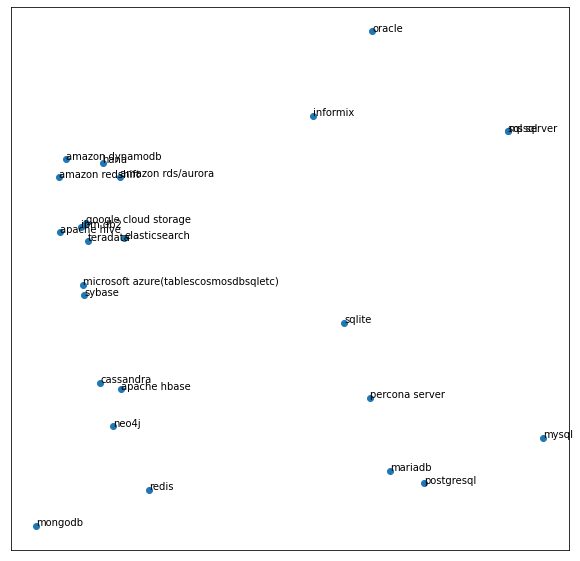

In [25]:
_, ax = plt.subplots(1, 1, figsize=(10, 10))
df_embedded = PCA(n_components=2).fit_transform(df_databases)
ax.scatter(df_embedded[:, 0], df_embedded[:, 1])
for lang, (x, y) in zip(df_databases.index, df_embedded):
    ax.annotate(lang, (x, y))
ax.set_xticks([]);
ax.set_yticks([]);

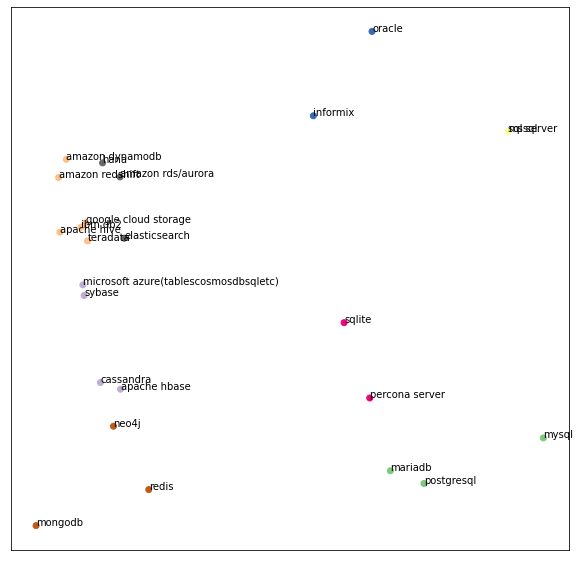

In [33]:
from sklearn.cluster import SpectralClustering
clustering = SpectralClustering(n_clusters=8, assign_labels="discretize", random_state=0).fit(df_embedded)
_, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.scatter(df_embedded[:, 0], df_embedded[:, 1], c=clustering.labels_, cmap='Accent')
for plat, (x, y) in zip(df_databases.index, df_embedded):
    ax.annotate(plat, (x, y))
ax.set_xticks([]);
ax.set_yticks([]);

In [30]:
best = {'colsample_bytree': 0.7000000000000001, 'gamma': 0.8500000000000001, 'learning_rate': 0.025, 'max_depth': 16, 'min_child_weight': 15.0, 'n_estimators': 175, 'subsample': 0.8099576733552297}
regions_map = {
    'Ciudad Autónoma de Buenos Aires': 'AMBA',
    'GBA': 'AMBA',
    'Catamarca': 'NOA',
    'Chaco': 'NEA',
    'Chubut': 'Patagonia',
    'Corrientes': 'NEA',
    'Entre Ríos': 'NEA',
    'Formosa': 'NEA',
    'Jujuy': 'NOA',
    'La Pampa': 'Pampa',
    'La Rioja': 'NOA',
    'Mendoza': 'Cuyo',
    'Misiones': 'NEA',
    'Neuquén': 'Patagonia',
    'Río Negro': 'Patagonia',
    'Salta': 'NOA',
    'San Juan': 'Cuyo',
    'San Luis': 'Cuyo',
    'Santa Cruz': 'Patagonia',
    'Santa Fe': 'Pampa',
    'Santiago del Estero': 'NOA',
    'Tucumán': 'NOA',
    'Córdoba': 'Pampa',
    'Provincia de Buenos Aires': 'Pampa',
    'Tierra del Fuego': 'Patagonia',
}
class BaseModel:
    def __init__(self, **params):
        self.regressor_ = xgb.XGBRegressor(**params)

    def get_params(self, deep=True):
        return self.regressor_.get_params(deep=deep)

    def set_params(self, **params):
        return self.regressor_.set_params(**params)
    
    def clean_words(self, field, value):
        value = value.replace('Microsoft Azure (Tables, CosmosDB, SQL, etc)', 'Microsoft Azure(TablesCosmosDBSQLetc)')
        value = value.replace('Snacks, golosinas, bebidas', 'snacks')
        value = value.replace('Descuentos varios (Clarín 365, Club La Nación, etc)', 'descuentos varios')
        value = value.replace('Sí, de forma particular', 'de forma particular')
        value = value.replace('Sí, los pagó un empleador', 'los pagó un empleador')
        value = value.replace('Sí, activa', 'activa')
        value = value.replace('Sí, pasiva', 'pasiva')
        return [self.clean_word(field, v) for v in value.split(',') if self.clean_word(field, v)]

    def clean_word(self, field, word):
        val = str(word).lower().strip().replace(".", "")
        if val in ('ninguno', 'ninguna', 'no', '0', 'etc)', 'nan'):
            return ''
        if field == 'Lenguajes de programación' and val == 'Microsoft Azure(TablesCosmosDBSQLetc)':
            return 'Microsoft Azure (Tables, CosmosDB, SQL, etc)'
        if field == '¿A qué eventos de tecnología asististe en el último año?' and val in ('pycon', 'pyconar'):
            return 'pyconar'
        if field == '¿A qué eventos de tecnología asististe en el último año?' and val in ('nodeconf', 'nodeconfar'):
            return 'nodeconfar'
        if field == '¿A qué eventos de tecnología asististe en el último año?' and val in ('meetup', 'meetups'):
            return 'meetups'
        if field == '¿A qué eventos de tecnología asististe en el último año?':
            return val.replace(' ', '')
        if field == 'Beneficios extra' and val == 'snacks':
            return 'snacks, golosinas, bebidas'
        if field == 'Beneficios extra' and val == 'descuentos varios':
            return 'descuentos varios (clarín 365, club la nación, etc)'
        return val

    def row_to_words(self, row):
        return [
            f'{key}={row.fillna("")[key]}'
            for key
            in (
                'Me identifico',
                'Nivel de estudios alcanzado',
                'Universidad',
                'Estado',
                'Carrera',
                '¿Contribuís a proyectos open source?',
                '¿Programás como hobbie?',
                'Trabajo de',
                '¿Qué SO usás en tu laptop/PC para trabajar?',
                '¿Y en tu celular?',
                'Tipo de contrato',
                'Orientación sexual',
                'Cantidad de empleados',
                'Actividad principal',
            )
        ] + [
            f'{k}={v}' for k in (
                '¿Tenés guardias?',
                'Realizaste cursos de especialización',
                '¿A qué eventos de tecnología asististe en el último año?',
                'Beneficios extra',
                'Plataformas',
                'Lenguajes de programación',
                'Frameworks, herramientas y librerías',
                'Bases de datos',
                'QA / Testing',
                'IDEs',
                'Lenguajes de programación'
            ) for v in self.clean_words(k, row.fillna('')[k])
        ] + [
            f'region={regions_map[row["Dónde estás trabajando"]]}'
        ]

    def encode_row(self, row):
        ws = self.row_to_words(row)
        return pd.Series([w in ws for w in self.valid_words_] + [
            row['¿Gente a cargo?'],
            row['Años de experiencia'],
            row['Tengo'],
        ])

    def fit(self, X, y, **params):
        counts = {}
        for i in range(X.shape[0]):
            for word in self.row_to_words(X.iloc[i]):
                counts[word] = counts.get(word, 0) + 1
        self.valid_words_ = [word for word, c in counts.items() if c > 0.01*X.shape[0]]
        self.regressor_.fit(X.apply(self.encode_row, axis=1).astype(float), y, **params)
        return self
   
    def predict(self, X):
        return self.regressor_.predict(X.apply(self.encode_row, axis=1).astype(float))
    
    def score(self, X, y):
        return r2_score(y, self.predict(X))
cross_val_score(BaseModel(), df, df['Salario mensual BRUTO (en tu moneda local)'])

array([0.49657124, 0.35863404, 0.54711517, 0.4280007 , 0.47291457])

In [34]:
database_embeddings = {l: [] for l in clustering.labels_}
for database, label in zip(df_databases.index, clustering.labels_):
    database_embeddings[label].append(database)
database_embeddings

{0: ['mysql', 'postgresql', 'mariadb'],
 3: ['mssql', 'sql server'],
 4: ['oracle', 'informix'],
 6: ['mongodb', 'redis', 'neo4j'],
 7: ['elasticsearch', 'amazon rds/aurora', 'hana'],
 5: ['sqlite', 'percona server'],
 1: ['microsoft azure(tablescosmosdbsqletc)',
  'cassandra',
  'sybase',
  'apache hbase'],
 2: ['amazon dynamodb',
  'google cloud storage',
  'ibm db2',
  'teradata',
  'amazon redshift',
  'apache hive']}

In [35]:
class ModelPCA:
    def __init__(self, **params):
        self.regressor_ = xgb.XGBRegressor(**params)

    def get_params(self, deep=True):
        return self.regressor_.get_params(deep=deep)

    def set_params(self, **params):
        return self.regressor_.set_params(**params)
    
    def clean_words(self, field, value):
        value = value.replace('Microsoft Azure (Tables, CosmosDB, SQL, etc)', 'Microsoft Azure(TablesCosmosDBSQLetc)')
        value = value.replace('Snacks, golosinas, bebidas', 'snacks')
        value = value.replace('Descuentos varios (Clarín 365, Club La Nación, etc)', 'descuentos varios')
        value = value.replace('Sí, de forma particular', 'de forma particular')
        value = value.replace('Sí, los pagó un empleador', 'los pagó un empleador')
        value = value.replace('Sí, activa', 'activa')
        value = value.replace('Sí, pasiva', 'pasiva')
        return [self.clean_word(field, v) for v in value.split(',') if self.clean_word(field, v)]

    def clean_word(self, field, word):
        val = str(word).lower().strip().replace(".", "")
        if val in ('ninguno', 'ninguna', 'no', '0', 'etc)', 'nan'):
            return ''
        if field == 'Lenguajes de programación' and val == 'Microsoft Azure(TablesCosmosDBSQLetc)':
            return 'Microsoft Azure (Tables, CosmosDB, SQL, etc)'
        if field == '¿A qué eventos de tecnología asististe en el último año?' and val in ('pycon', 'pyconar'):
            return 'pyconar'
        if field == '¿A qué eventos de tecnología asististe en el último año?' and val in ('nodeconf', 'nodeconfar'):
            return 'nodeconfar'
        if field == '¿A qué eventos de tecnología asististe en el último año?' and val in ('meetup', 'meetups'):
            return 'meetups'
        if field == '¿A qué eventos de tecnología asististe en el último año?':
            return val.replace(' ', '')
        if field == 'Beneficios extra' and val == 'snacks':
            return 'snacks, golosinas, bebidas'
        if field == 'Beneficios extra' and val == 'descuentos varios':
            return 'descuentos varios (clarín 365, club la nación, etc)'
        return val

    def contains_database(self, row, databases):
        k = 'Bases de datos'
        for v in self.clean_words(k, row.fillna('')[k]):
            if v in databases:
                return True
        return False

    def row_to_words(self, row):
        return [
            f'{key}={row.fillna("")[key]}'
            for key
            in (
                'Me identifico',
                'Nivel de estudios alcanzado',
                'Universidad',
                'Estado',
                'Carrera',
                '¿Contribuís a proyectos open source?',
                '¿Programás como hobbie?',
                'Trabajo de',
                '¿Qué SO usás en tu laptop/PC para trabajar?',
                '¿Y en tu celular?',
                'Tipo de contrato',
                'Orientación sexual',
                'Cantidad de empleados',
                'Actividad principal',
            )
        ] + [
            f'{k}={v}' for k in (
                '¿Tenés guardias?',
                'Realizaste cursos de especialización',
                '¿A qué eventos de tecnología asististe en el último año?',
                'Beneficios extra',
                'Plataformas',
                'Frameworks, herramientas y librerías',
                'Bases de datos',
                'QA / Testing',
                'IDEs',
                'Lenguajes de programación'
            ) for v in self.clean_words(k, row.fillna('')[k])
        ] + [
            f'region={regions_map[row["Dónde estás trabajando"]]}'
        ] + [
            f'database_type={i}'
            for i, databases in database_embeddings.items()
            if self.contains_database(row, databases)
        ]

    def encode_row(self, row):
        ws = self.row_to_words(row)
        return pd.Series([w in ws for w in self.valid_words_] + [
            row['¿Gente a cargo?'],
            row['Años de experiencia'],
            row['Tengo'],
        ])

    def fit(self, X, y, **params):
        counts = {}
        for i in range(X.shape[0]):
            for word in self.row_to_words(X.iloc[i]):
                counts[word] = counts.get(word, 0) + 1
        self.valid_words_ = [word for word, c in counts.items() if c > 0.01*X.shape[0]]
        self.regressor_.fit(X.apply(self.encode_row, axis=1).astype(float), y, **params)
        return self
   
    def predict(self, X):
        return self.regressor_.predict(X.apply(self.encode_row, axis=1).astype(float))
    
    def score(self, X, y):
        return r2_score(y, self.predict(X))
cross_val_score(ModelPCA(), df, df['Salario mensual BRUTO (en tu moneda local)'])

array([0.48752962, 0.36787491, 0.52101172, 0.43112294, 0.42272244])